In [60]:
import sys
principal_path = '../'
if principal_path not in sys.path:
    sys.path.append('../')

In [90]:
import pandas as pd
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

from utils import *
from models.MNISTModelWithBottelNeck import MNISTModelWithBottelNeck
from PruningMLP import PruningMLP
import copy

In [62]:
FOLDER = 'activations'
FILE = 'activations_minist_model_bottel_neck.csv'

In [63]:
df = pd.read_csv(os.path.join(FOLDER, FILE))

In [64]:
#get neurons of layer_1
layer_1_columns = [col for col in df.columns if 'layer_1' in col]
layer_1 = df[layer_1_columns]

In [65]:
# aplly TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(layer_1.values)


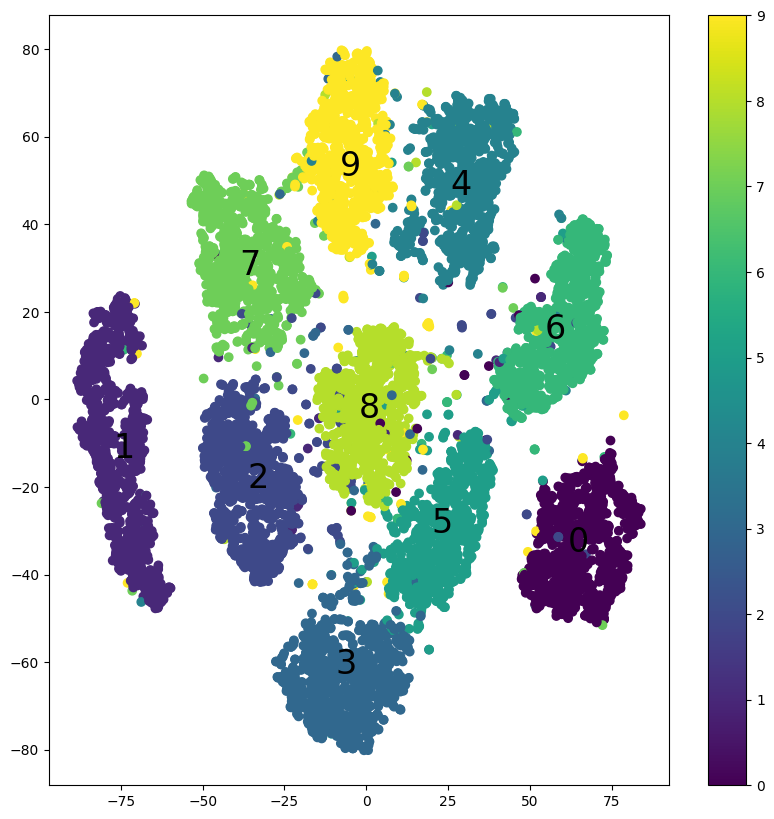

In [66]:
# plot
# Suponiendo que tsne_obj es tu array de coordenadas y df['Number'] contiene las etiquetas de los clusters
plt.figure(figsize=(10, 10))
plt.scatter(tsne_obj[:, 0], tsne_obj[:, 1], c=df['Number'])

# Calcular y poner el número en el centroide de cada cluster
for i in range(10):
    # Obtiene las coordenadas de los puntos en el cluster actual
    points_in_cluster = tsne_obj[df['Number'] == i]
    
    # Calcula el centroide del cluster
    centroid = np.mean(points_in_cluster, axis=0)
    
    # Pone el número en el centroide
    plt.text(centroid[0], centroid[1], str(i), fontsize=24, ha='center', va='center')

plt.colorbar()
plt.show()

In [67]:
#get neurons of layer_2
layer_2_columns = [col for col in df.columns if 'layer_2' in col]
layer_2 = df[layer_2_columns]

# aplly TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(layer_2.values)

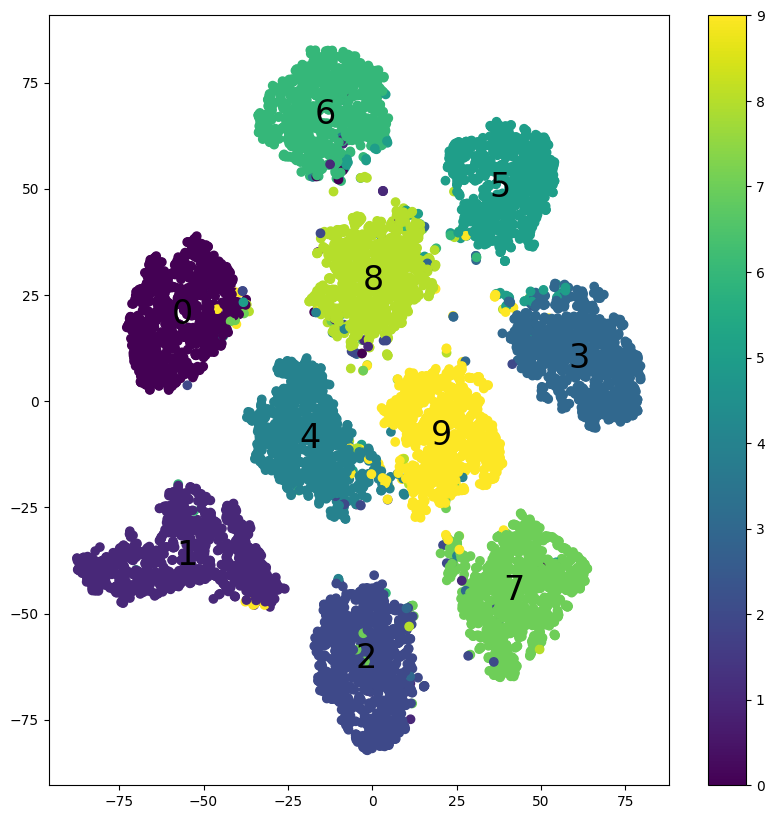

In [68]:
# Suponiendo que tsne_obj es tu array de coordenadas y df['Number'] contiene las etiquetas de los clusters
plt.figure(figsize=(10, 10))
plt.scatter(tsne_obj[:, 0], tsne_obj[:, 1], c=df['Number'])

# Calcular y poner el número en el centroide de cada cluster
for i in range(10):
    # Obtiene las coordenadas de los puntos en el cluster actual
    points_in_cluster = tsne_obj[df['Number'] == i]
    
    # Calcula el centroide del cluster
    centroid = np.mean(points_in_cluster, axis=0)
    
    # Pone el número en el centroide
    plt.text(centroid[0], centroid[1], str(i), fontsize=24, ha='center', va='center')

plt.colorbar()
plt.show()

## Pruning

In [69]:
SEED = 2024
BATCH_SIZE = 32
pl.seed_everything(SEED)

Seed set to 2024


2024

In [79]:
checkpoint_ffn = 'checkpoints/mnist_model_bottel_neck.ckpt'
model = MNISTModelWithBottelNeck.load_from_checkpoint(checkpoint_ffn)
model.eval()
print(model)

MNISTModelWithBottelNeck(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=784, bias=True)
  (layer_3): Linear(in_features=784, out_features=10, bias=True)
)


In [71]:
df = pd.read_csv(os.path.join(FOLDER, FILE))
df.head()

,Number,layer_1_Neuron1,layer_1_Neuron2,layer_1_Neuron3,layer_1_Neuron4,layer_1_Neuron5,layer_1_Neuron6,layer_1_Neuron7,layer_1_Neuron8,layer_1_Neuron9,...,layer_3_Neuron1,layer_3_Neuron2,layer_3_Neuron3,layer_3_Neuron4,layer_3_Neuron5,layer_3_Neuron6,layer_3_Neuron7,layer_3_Neuron8,layer_3_Neuron9,layer_3_Neuron10
0,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.376383,0.0,0.294046,0.0,...,-15.637275,-17.848444,-15.032040,-10.468901,-20.681240,-19.418213,-26.472775,-0.000142,-18.147480,-9.087777
1,2.0,0.000000,0.244701,0.372548,0.596361,0.000000,0.000000,0.0,0.000000,0.0,...,-22.694475,-13.046512,-0.000002,-18.819792,-34.102146,-20.676405,-21.301588,-18.435421,-28.044016,-38.853397
2,1.0,0.263735,0.256444,0.000000,0.555110,0.000000,0.000000,0.0,0.000000,0.0,...,-25.263477,-0.000008,-14.519335,-19.675426,-17.670179,-19.739429,-20.180361,-11.856068,-17.683435,-27.857590
3,0.0,0.000000,0.000000,0.207519,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,-0.000009,-20.509430,-11.990640,-22.504074,-18.058376,-20.262209,-14.357120,-13.108961,-20.496691,-14.555052
4,4.0,0.000000,0.000000,0.000000,0.000000,0.728545,0.652585,0.0,0.000000,0.0,...,-14.574787,-11.154149,-17.313587,-20.613903,-0.000840,-18.439859,-20.343086,-10.061741,-20.457092,-7.153463


In [72]:
classes_to_include = [0, 1]
train_loader_filtered, val_loader_filtered, test_loader_filtered = load_data_filtered(BATCH_SIZE, classes_to_include, num_workers=0)

In [73]:
# trainer
trainer = pl.Trainer(max_epochs=5)
# test model
trainer.test(model, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 134.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.8994681239128113
        precision            0.90266352891922
         recall             0.8964942097663879
        test_acc            0.9900709390640259
        test_loss          0.055399585515260696
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.055399585515260696,
  'test_acc': 0.9900709390640259,
  'precision': 0.90266352891922,
  'recall': 0.8964942097663879,
  'f1': 0.8994681239128113}]

In [80]:
pruning = PruningMLP(classes_to_include)

In [87]:

model_copy = copy.deepcopy(model)
model_pruning = pruning.prune(model_copy, df, {'layer_1': 0.6})

In [88]:
print(model_pruning)
print(model)

MNISTModelWithBottelNeck(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=15, bias=True)
  (layer_2): Linear(in_features=15, out_features=784, bias=True)
  (layer_3): Linear(in_features=784, out_features=10, bias=True)
)
MNISTModelWithBottelNeck(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=784, bias=True)
  (layer_3): Linear(in_features=784, out_features=10, bias=True)
)


In [89]:
# trainer
trainer = pl.Trainer(max_epochs=5)
# test model
trainer.test(model_pruning, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 123.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.8617741465568542
        precision           0.8663516044616699
         recall             0.8575206398963928
        test_acc             0.985342800617218
        test_loss            0.199873149394989
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.199873149394989,
  'test_acc': 0.985342800617218,
  'precision': 0.8663516044616699,
  'recall': 0.8575206398963928,
  'f1': 0.8617741465568542}]